# Import Library & Dataset

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = '../data/cleaned_outliers_data_saudi_used_cars.csv'
OUTPUT_PATH = '../data/feature_engineered_saudi_used_cars.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(3816, 11)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000


# Feature Engineering

## Feature Creation

### Car Age

In [2]:
# -- Car Age: More predictive than raw Year --
CURRENT_YEAR = 2022
df['Car_Age'] = CURRENT_YEAR - df['Year']
# Business logic: car age is a more monotonic predictor of price drop
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,8
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,7
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,7
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,3
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,10


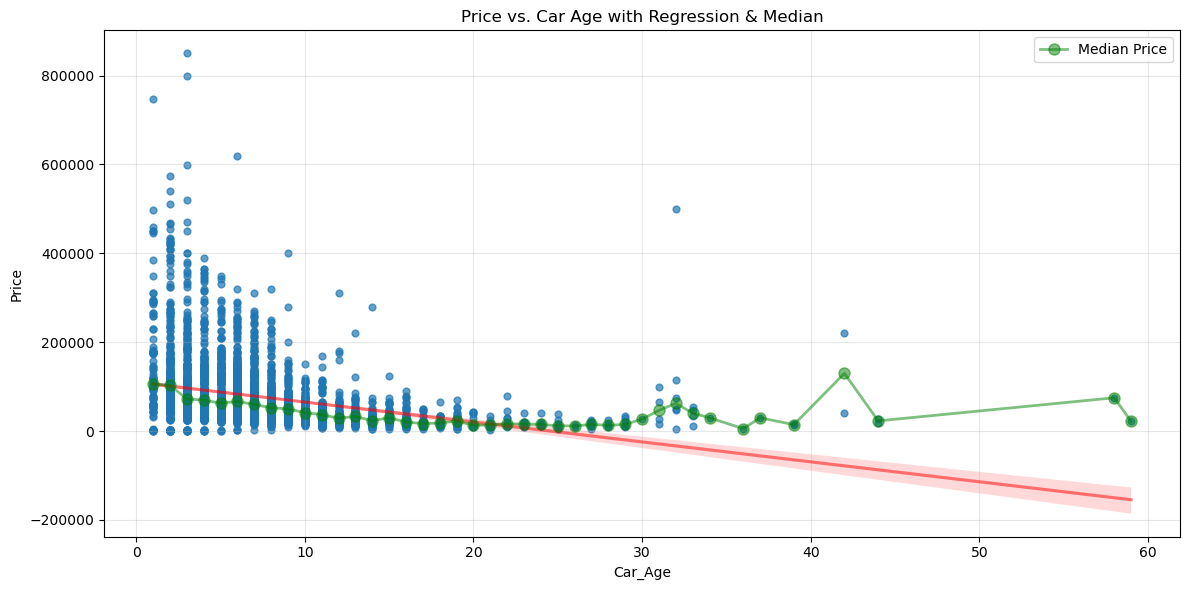

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_relationship(
    df, 
    x_col, 
    y_col, 
    show_medians=True, 
    figsize=(12,6), 
    scatter_alpha=0.5,
    reg_color='red',
    median_color='green',
    median_label='Median Y',
    ylim=None,
    xlim=None,
    median_kwargs=None,
    reg_kwargs=None,
    title=None
):
    """
    Plots y_col vs. x_col with regression line and optional median y per unique x value.

    Args:
        df (pd.DataFrame): DataFrame with data.
        x_col (str): Name of x-axis column (must be numeric/discrete).
        y_col (str): Name of y-axis column.
        show_medians (bool): Plot median y per x if True.
        figsize (tuple): Figure size.
        scatter_alpha (float): Alpha for scatter.
        reg_color (str): Color for regression line.
        median_color (str): Color for median line.
        median_label (str): Legend label for median.
        ylim (tuple or None): Y-axis limits.
        xlim (tuple or None): X-axis limits.
        median_kwargs (dict or None): Additional kwargs for median line.
        reg_kwargs (dict or None): Additional kwargs for sns.regplot().
        title (str or None): Custom plot title.
    """
    plt.figure(figsize=figsize)
    # Regression and scatter
    regplot_kwargs = dict(
        x=x_col,
        y=y_col,
        data=df,
        scatter_kws={'alpha': scatter_alpha, 's': 24},
        line_kws={'color': reg_color, 'alpha': 0.5},
    )
    if reg_kwargs:
        regplot_kwargs.update(reg_kwargs)
    sns.regplot(**regplot_kwargs)
    
    # Median line (for discrete/ordinal/nice integer x)
    if show_medians:
        unique_x = np.sort(df[x_col].unique())
        medians = df.groupby(x_col)[y_col].median().reindex(unique_x)
        mkws = dict(color=median_color, linewidth=2, markersize=8, label=median_label, alpha=0.5)
        if median_kwargs:
            mkws.update(median_kwargs)
        plt.plot(unique_x, medians, 'o-', **mkws)
        plt.legend()
    if title is not None:
        plt.title(title)
    else:
        plt.title(f'{y_col} vs. {x_col} (Regression{" & Median" if show_medians else ""})')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True, alpha=0.3)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()
    
plot_numeric_relationship(
    df, 
    x_col='Car_Age', 
    y_col='Price', 
    show_medians=True, 
    figsize=(12, 6), 
    scatter_alpha=0.7,
    reg_color='red',
    median_color='green',
    median_label='Median Price',
    title='Price vs. Car Age with Regression & Median'
)

In [4]:
correlation_car_age = df['Car_Age'].corr(df['Price'])
print(f"Correlation between Car Age and Price: {correlation_car_age:.4f}")

# Compute correlation between Year and Price
correlation_year = df['Year'].corr(df['Price'])
print(f"Correlation between Year and Price: {correlation_year:.4f}")

Correlation between Car Age and Price: -0.3152
Correlation between Year and Price: 0.3152


Feature Engineering: Car Age

Why Create `Car_Age`?

* **Business Logic:**
  In the used car market, the age of a car (number of years since it was manufactured) is a stronger and more direct predictor of price than the raw year. Buyers and sellers primarily think in terms of how old a car is, not in which year it was made. Depreciation is typically a monotonic function of car age—newer cars command higher prices and older cars steadily lose value.

* **Data Science Best Practice:**
  Converting `Year` to `Car_Age` (`Car_Age = Current_Year - Year`) linearizes the relationship with price, making it easier for most machine learning algorithms to learn the underlying pattern. This transformation also reduces the risk of the model overfitting to specific years and helps capture general depreciation trends more robustly.

Relationship to Price

* There is a clear negative correlation between car age and price.

  * As `Car_Age` increases, car price decreases.
  * In this dataset, the correlation between Car Age and Price is approximately -0.32.
  * The correlation between Year and Price is approximately +0.32, which is the inverse, as expected.

* This monotonic and interpretable relationship improves both model performance and business explainability.

Visualization & Impact

* The price versus car age plot demonstrates a steady decline in price as car age increases, consistent with standard depreciation curves seen in the automotive industry.
* The effect is strongest in the first several years, after which prices stabilize or level off for very old or collector vehicles.

### Vintage Cars (IsVintage)

In [5]:
# -- Vintage Flag: Flag cars that are "classic" or "vintage", which is indicated by a Car Age of 30 years or older --
df['IsVintage'] = (df['Car_Age'] >= 30)
df[df['IsVintage']].head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age,IsVintage
42,SEL,Tabouk,Mercedes,Automatic,Saudi,Full,1986,3.0,500000,False,5500,36,True
205,Land Cruiser Pickup,Aseer,Toyota,Manual,Saudi,Standard,1983,1.5,2580,False,15000,39,True
287,SEL,Dammam,Mercedes,Automatic,Other,Full,1990,4.0,89000,False,75000,32,True
444,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000,42,True
960,Land Cruiser,Najran,Toyota,Manual,Saudi,Semi Full,1988,4.0,195000,False,30000,34,True


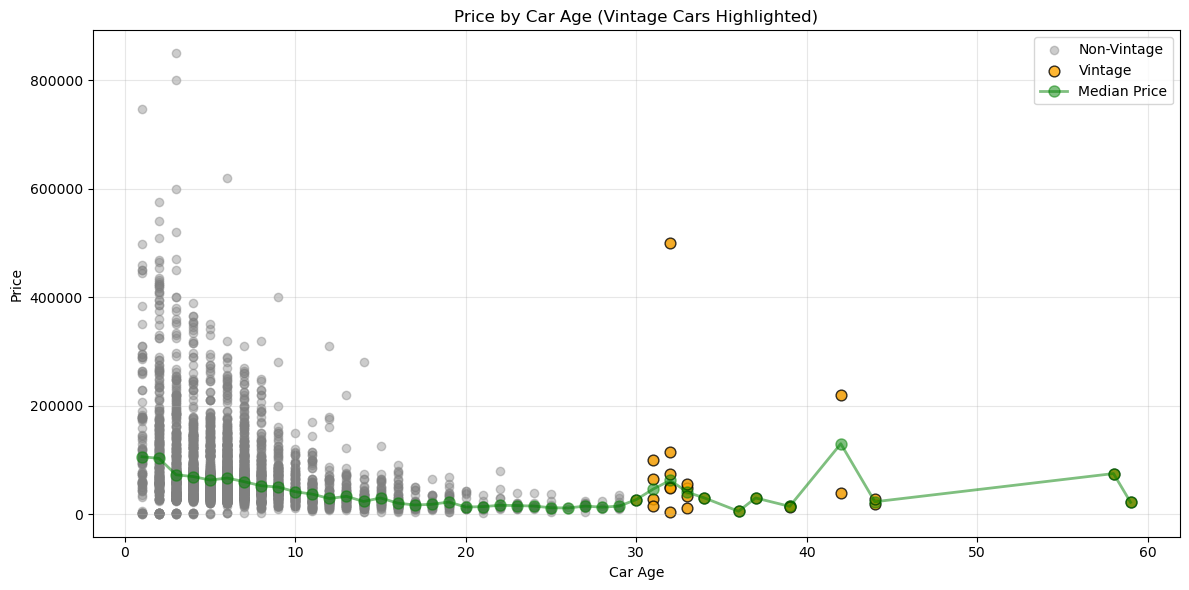

In [6]:
plt.figure(figsize=(12, 6))
# Plot all cars
plt.scatter(df['Car_Age'], df['Price'], alpha=0.4, label='Non-Vintage', color='gray')
# Highlight vintage cars
vintage_mask = df['IsVintage'] == True
plt.scatter(df.loc[vintage_mask, 'Car_Age'], df.loc[vintage_mask, 'Price'], 
            alpha=0.8, label='Vintage', color='orange', edgecolor='black', s=60)

# Median price per Car_Age
medians = df.groupby('Car_Age')['Price'].median()
plt.plot(medians.index, medians.values, 'o-', color='green', linewidth=2, markersize=8, label='Median Price', alpha=0.5)

plt.xlabel('Car Age')
plt.ylabel('Price')
plt.title('Price by Car Age (Vintage Cars Highlighted)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Vintage Cars Flag (`IsVintage`)

A new feature called **IsVintage** is introduced to flag listings for cars considered "vintage" or "classic," defined here as those with a car age of **30 years or older**. This binary feature enables the model to distinguish between mainstream used cars and older, potentially collectible vehicles that often exhibit unique pricing behavior and appeal to different market segments.

By introducing this flag, the model can handle these special cases appropriately, without allowing their atypical pricing patterns to distort predictions for the majority of modern used cars. This is especially important in the Saudi market, where vintage vehicles are rare but may attract highly variable prices.

### Big Engine Cars (IsBigEngine)

In [7]:
# -- Big Engine Flag: Flag abnormally high-performance vehicles
df['IsBigEngine'] = (df['Engine_Size'] > 7.0)
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age,IsVintage,IsBigEngine
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,8,False,True
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,7,False,False
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,7,False,False
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,3,False,False
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,10,False,False


Another engineered feature, **IsBigEngine**, flags listings with **engine sizes greater than 7.0 liters**. Vehicles with such large engines are uncommon in the mainstream market and are typically high-performance, luxury, or customized vehicles.

Rather than removing these entries as outliers, this flag enables the model to learn from these rare but potentially important cases, capturing the significant price premium often associated with abnormally large engine sizes. This ensures that predictions remain robust across a diverse range of vehicles, from everyday sedans to rare, high-end models.

## Feature Transformation

Log-transform skewed numerical columns

In [ ]:
def analyze_features(df, target_var='Price', low_card_thresh=10):
  """
  Analyze dataframe features for modeling:
  - Identifies categorical and numerical columns (excluding target)
  - Detects highly skewed numeric columns
  - Splits categoricals into low/high cardinality
  - Prints summary

  Returns:
    cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat
  """
  # Categorical columns for future pipeline/modeling
  cat_cols = (
    df
      .select_dtypes(include=['object','bool','category'])
      .drop(columns=[target_var], errors='ignore')
      .columns
      .tolist()
  )

  # Numerical columns (excluding target)
  num_cols = (
    df
      .select_dtypes(include=['int64','float64'])
      .drop(columns=[target_var])
      .columns
      .tolist()
  )

  print("Categorical variables:", cat_cols)
  print("Numerical variables:", num_cols)
  print("Target variable:", target_var)

  # detect highly-skewed numerics for log1p transform
  skewed_cols = [c for c in num_cols if abs(df[c].skew()) > 1.0]
  print("Highly skewed numeric columns:", skewed_cols)

  print("\n>> category cardinalities:")
  for c in cat_cols:
    print(f"   {c:12s}: {df[c].nunique()} categories")

  # split them into "low-cardinality" vs "high-cardinality"
  low_card_cat  = [c for c in cat_cols if df[c].nunique() <= low_card_thresh]
  high_card_cat = [c for c in cat_cols if df[c].nunique() >  low_card_thresh]

  # a quick sanity check
  print("\n>> low-cardinal cats:",  low_card_cat)
  print(">> high-cardinal cats:", high_card_cat)
  print(">> numeric cols:     ",  num_cols)
  print(">> skewed cols:     ",  skewed_cols)

  return cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat

In [9]:
cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat = analyze_features(df)

Categorical variables: ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'Negotiable', 'IsVintage', 'IsBigEngine']
Numerical variables: ['Year', 'Engine_Size', 'Mileage', 'Car_Age']
Target variable: Price
Highly skewed numeric columns: ['Year', 'Mileage', 'Car_Age']

>> category cardinalities:
   Type        : 320 categories
   Region      : 27 categories
   Make        : 56 categories
   Gear_Type   : 2 categories
   Origin      : 4 categories
   Options     : 3 categories
   Negotiable  : 1 categories
   IsVintage   : 2 categories
   IsBigEngine : 2 categories

>> low-cardinal cats: ['Gear_Type', 'Origin', 'Options', 'Negotiable', 'IsVintage', 'IsBigEngine']
>> high-cardinal cats: ['Type', 'Region', 'Make']
>> numeric cols:      ['Year', 'Engine_Size', 'Mileage', 'Car_Age']
>> skewed cols:      ['Year', 'Mileage', 'Car_Age']


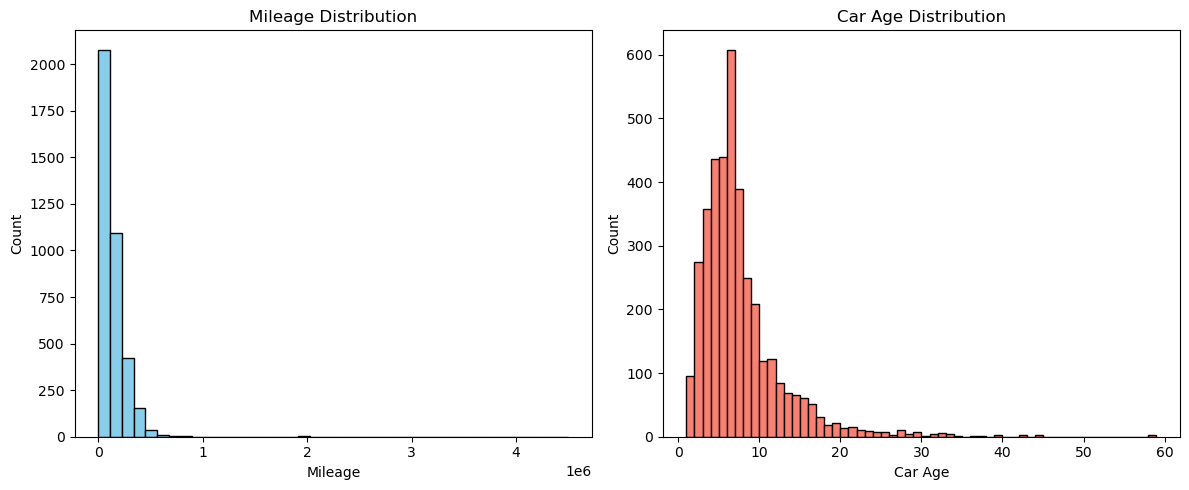

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mileage distribution
axes[0].hist(df['Mileage'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_title('Mileage Distribution')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Count')

# Car_Age distribution
axes[1].hist(df['Car_Age'], bins=range(df['Car_Age'].min(), df['Car_Age'].max() + 1), color='salmon', edgecolor='black')
axes[1].set_title('Car Age Distribution')
axes[1].set_xlabel('Car Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
# -- Log Transform for Skewed Numeric Features --
df['log_Mileage'] = np.log1p(df['Mileage'])
display(df[['log_Mileage', 'Mileage']].sort_values(by='log_Mileage').head())
display(df[['log_Mileage', 'Mileage']].sort_values(by='log_Mileage').tail())

,log_Mileage,Mileage
2640,4.615121,100
3086,4.615121,100
2091,4.615121,100
3398,4.615121,100
573,4.615121,100


,log_Mileage,Mileage
3309,14.962913,3150000
622,14.972393,3180003
3090,15.009433,3300000
954,15.068274,3500000
383,15.319588,4500000


In [12]:
# -- Log Transform for Skewed Numeric Features --
df['log_Car_Age'] = np.log1p(df['Car_Age'])
display(df[['log_Car_Age', 'Car_Age']].sort_values(by='log_Car_Age').head())
display(df[['log_Car_Age', 'Car_Age']].sort_values(by='log_Car_Age').tail())

,log_Car_Age,Car_Age
3233,0.693147,1
1037,0.693147,1
2968,0.693147,1
2005,0.693147,1
1555,0.693147,1


,log_Car_Age,Car_Age
2896,3.761200,42
2204,3.806662,44
2097,3.806662,44
1531,4.077537,58
3406,4.094345,59


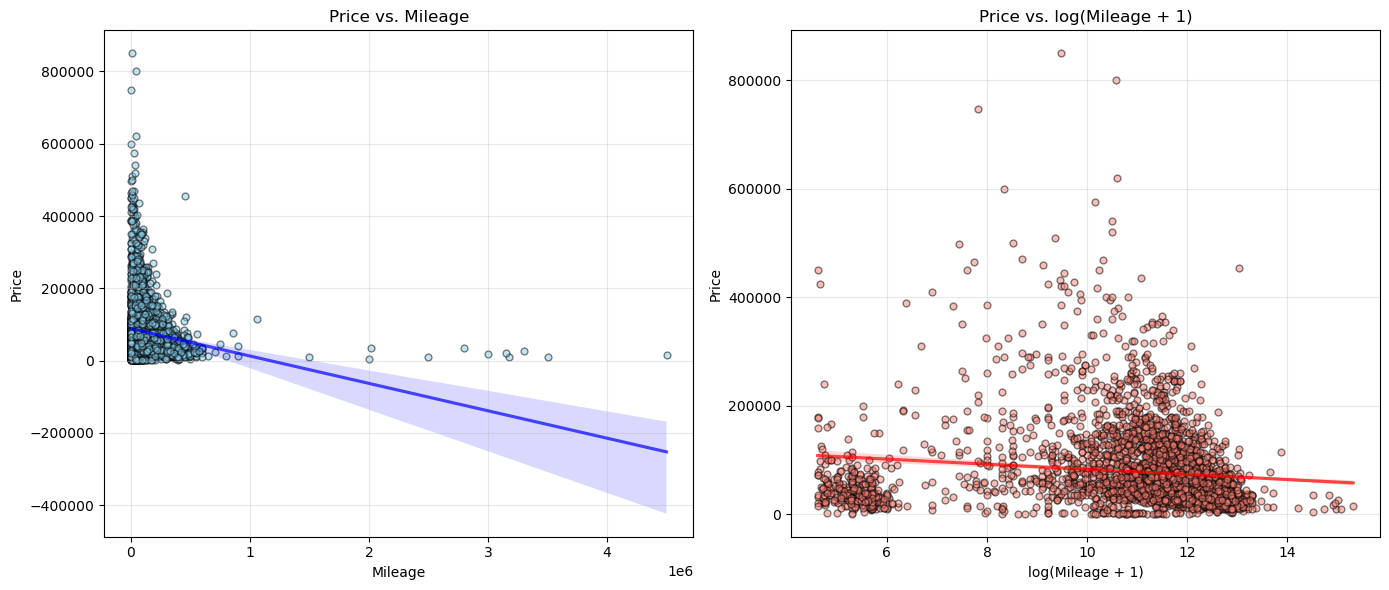

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot + regplot: Mileage vs Price
axes[0].scatter(df['Mileage'], df['Price'], alpha=0.5, color='skyblue', edgecolor='k', s=24)
sns.regplot(x='Mileage', y='Price', data=df, scatter=False, ax=axes[0], color='blue', line_kws={'alpha':0.7})
axes[0].set_title('Price vs. Mileage')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Price')
axes[0].grid(alpha=0.3)

# Scatterplot + regplot: log_Mileage vs Price
axes[1].scatter(df['log_Mileage'], df['Price'], alpha=0.5, color='salmon', edgecolor='k', s=24)
sns.regplot(x='log_Mileage', y='Price', data=df, scatter=False, ax=axes[1], color='red', line_kws={'alpha':0.7})
axes[1].set_title('Price vs. log(Mileage + 1)')
axes[1].set_xlabel('log(Mileage + 1)')
axes[1].set_ylabel('Price')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

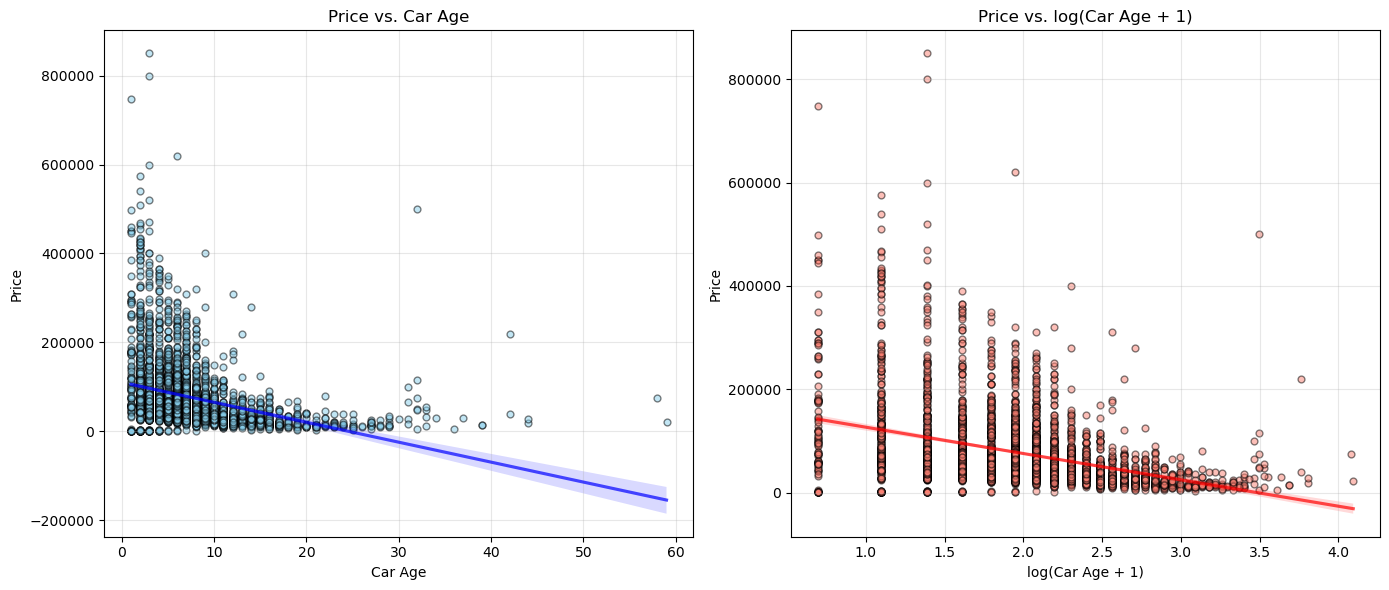

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot + regplot: Car_Age vs Price
axes[0].scatter(df['Car_Age'], df['Price'], alpha=0.5, color='skyblue', edgecolor='k', s=24)
sns.regplot(x='Car_Age', y='Price', data=df, scatter=False, ax=axes[0], color='blue', line_kws={'alpha':0.7})
axes[0].set_title('Price vs. Car Age')
axes[0].set_xlabel('Car Age')
axes[0].set_ylabel('Price')
axes[0].grid(alpha=0.3)

# Scatterplot + regplot: log_Car_Age vs Price
axes[1].scatter(df['log_Car_Age'], df['Price'], alpha=0.5, color='salmon', edgecolor='k', s=24)
sns.regplot(x='log_Car_Age', y='Price', data=df, scatter=False, ax=axes[1], color='red', line_kws={'alpha':0.7})
axes[1].set_title('Price vs. log(Car Age + 1)')
axes[1].set_xlabel('log(Car Age + 1)')
axes[1].set_ylabel('Price')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Log-Transformation of Skewed Features

In real-world datasets, some numerical features often display a **highly skewed distribution**—where most values cluster toward the lower end, with a long tail of extreme (large) values. In the context of used car data, both **Mileage** and **Car Age** are classic examples of such variables.

Why Use Log-Transformation?

* **Reduces Skewness:**
  Raw distributions of Mileage and Car Age are highly right-skewed (see left plots below). This can make it harder for many machine learning models, especially linear models, to learn accurate relationships, since the model is overly influenced by extreme outliers.
* **Improves Linearity:**
  Many algorithms (including linear regression) perform better when relationships between features and target are more linear. Log-transforming these features can help “straighten out” the curves, making patterns easier to capture.
* **Stabilizes Variance:**
  It compresses large values more than small values, making the spread of the data more consistent.

How Was Log-Transformation Applied?

For each highly-skewed numerical column (skewness > 1), a log-transform (specifically, `log(x+1)`) was applied. This transformation is safe even for zeros, as adding one avoids taking the log of zero.

Visual Impact

The right-side plots below compare the relationship of the original and log-transformed variables with **Price**:

* **Left:** Raw feature vs. Price—notice the strong right skew and non-linear trend.
* **Right:** Log-transformed feature vs. Price—notice improved spread and a more linear pattern, especially for Mileage.

Feature Engineering Pipeline Integration

* Highly-skewed numeric columns are identified programmatically (e.g., `Mileage`, `Car_Age`).
* Log-transformed versions are used as model inputs where beneficial, especially for models sensitive to feature distributions (e.g., ElasticNet, KNN).
* For tree-based models (CatBoost, XGBoost), log-transform may not be necessary, as trees handle skew and non-linearity natively.

Summary

**Log-transforming** skewed features like Mileage and Car Age:

* Makes distributions closer to normal,
* Improves model performance and interpretability,
* Is an industry-standard best practice for tabular regression problems with extreme value ranges.

## Feature Selection

In [15]:
# -- Drop Columns Not Needed for Modeling --
drop_cols = ['Negotiable', 'Mileage_per_Year', 'Unnatural_High_Mileage_Flag', 'Year']
for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=col)
# Negotiable: already removed from pipeline.
# Mileage_per_Year, Unnatural_High_Mileage_Flag: only for outlier detection, not features.
# Year: we already created 'Car_Age' from it, so it's redundant.

df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,Car_Age,IsVintage,IsBigEngine,log_Mileage,log_Car_Age
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,8.0,80000,120000,8,False,True,11.289794,2.197225
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,5.0,140000,260000,7,False,False,11.849405,2.079442
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2.4,220000,42000,7,False,False,12.301387,2.079442
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2.0,25000,58000,3,False,False,10.126671,1.386294
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,4.8,189000,85000,10,False,False,12.149508,2.397895


In [16]:
cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat = analyze_features(df)

Categorical variables: ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
Numerical variables: ['Engine_Size', 'Mileage', 'Car_Age', 'log_Mileage', 'log_Car_Age']
Target variable: Price
Highly skewed numeric columns: ['Mileage', 'Car_Age', 'log_Mileage']

>> category cardinalities:
   Type        : 320 categories
   Region      : 27 categories
   Make        : 56 categories
   Gear_Type   : 2 categories
   Origin      : 4 categories
   Options     : 3 categories
   IsVintage   : 2 categories
   IsBigEngine : 2 categories

>> low-cardinal cats: ['Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
>> high-cardinal cats: ['Type', 'Region', 'Make']
>> numeric cols:      ['Engine_Size', 'Mileage', 'Car_Age', 'log_Mileage', 'log_Car_Age']
>> skewed cols:      ['Mileage', 'Car_Age', 'log_Mileage']


Pipeline for Feature Selection

In [17]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class DropColumns(BaseEstimator, TransformerMixin):
#     """Transformer to drop a fixed list of columns."""
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X, y=None):
#         # nothing to learn
#         return self

#     def transform(self, X):
#         # we expect X to be a DataFrame
#         return X.drop(columns=self.columns, errors="ignore")

Pipeline for Feature Engineering

In [18]:
# from sklearn.base import BaseEstimator, TransformerMixin

# CURRENT_YEAR = 2022

# class FeatureEngineer(BaseEstimator, TransformerMixin):
#     def __init__(self, current_year=CURRENT_YEAR):
#         self.current_year = current_year

#     def fit(self, X, y=None):
#         # nothing to learn
#         return self

    # def transform(self, X):
    #     # take a DataFrame (raw CSV) and return engineered DataFrame
    #     df = X.copy()

    #     # 1) Car age
    #     df["Car_Age"] = self.current_year - df["Year"]

    #     # 2) Vintage flag
    #     df["IsVintage"] = (df["Car_Age"] >= 30)

    #     # 3) Big engine flag ( >7L )
    #     df["IsBigEngine"] = (df["Engine_Size"] > 7.0)

    #     # 4) drop unused
    #     df = df.drop(columns=["Negotiable", "Mileage_per_Year", 
    #                           "Unnatural_High_Mileage_Flag", "Year"],
    #                  errors="ignore")

#         return df

The code for feature engineering above has been moved to `custom_pipeline_utils.py` to allow the model's joblib file to be accessible from other files.

To use it, simply import it below.

In [19]:
from custom_pipeline_utils import FeatureEngineer, DropColumns

In [20]:
FeatureEngineer = FeatureEngineer()
FeatureEngineer

FeatureEngineer()

In [22]:
DropColumns = DropColumns(columns=drop_cols)
DropColumns

DropColumns(columns=['Negotiable', 'Mileage_per_Year',
                     'Unnatural_High_Mileage_Flag', 'Year'])

Feature Selection & Engineering Pipeline

**Dropping Redundant and Helper Columns**

Before modeling, it is important to remove features that are either:

* No longer needed (e.g., replaced by engineered features)
* Only used for outlier detection
* Not relevant to the price prediction task

The following columns are dropped:

* `Negotiable`: Already filtered out during data cleaning.
* `Mileage_per_Year`, `Unnatural_High_Mileage_Flag`: Used only for outlier detection, not for model training.
* `Year`: Replaced by `Car_Age` which is a more predictive and interpretable feature for price.

**Feature Engineering Pipeline**

Feature engineering and selection are encapsulated in a modular pipeline, ensuring all transformations are reproducible and can be reused during inference and deployment.

**Key engineered features include:**

* **Car\_Age:** More predictive than the raw registration year, directly models depreciation.
* **IsVintage:** Flags cars older than 30 years as 'vintage/classic', which often behave differently in pricing.
* **IsBigEngine:** Flags vehicles with engine sizes greater than 7.0L, helping the model handle rare, high-performance cars.


In [23]:
# -----------------------------------------------------------
# Save Feature-Engineered Data (For Manual Inspection Only)
# -----------------------------------------------------------
df.to_csv(OUTPUT_PATH, index=False)
print(f"Feature engineered data saved to {OUTPUT_PATH}")

# Reminder: For real modeling, pipeline will be used to engineer features, not this CSV

Feature engineered data saved to ../data/feature_engineered_saudi_used_cars.csv
